In [121]:
import numpy as np
import scipy.signal as sig
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt
# import h5py
from functools import partial
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
import os
print(os.getcwd())
# from utils.classes.ResonanceFitResult import *
#from DaqUtils.UsrpFunctions import read_vna

/central/home/xjw/workdir/qkid/PAA-KIPM/notebooks


In [122]:
import numpy as np
import matplotlib.pyplot as plt

def load_noise_data(filename):
    freqs = []
    s21_values = []

    with open(filename, 'r') as f:
        for line in f:
            # Skip comment or metadata lines
            if line.strip().startswith('!'):
                continue

            # Split the line into parts
            parts = line.strip().split()
            if len(parts) >= 2:
                freq = float(parts[0].split(",")[0])
                s21 = float(parts[1])
                freqs.append(freq)
                s21_values.append(s21)
                # except ValueError:
                #     continue  # Skip lines with non-numeric data

    return np.array(freqs), np.array(s21_values)

def overlay_traces(file_list, file_leg):
    plt.figure(figsize=(8, 4))

    for i, file in enumerate(file_list):
        freqs, s21 = load_noise_data(file)
        freqs_mhz = freqs / 1e6
        plt.plot(freqs_mhz, s21, '-', label=file_leg[i])

    plt.xlabel('Frequency (MHz)')
    plt.ylabel('S21 (dB)')
    plt.title('Overlayed Noise Traces')
    plt.grid(True)
    plt.legend()
    plt.xlim(30, 300)
    # plt.ylim(-1.005, -0.995)  # Adjust if needed
    plt.tight_layout()
    plt.show()
    return freqs, s21

In [123]:
def peak_search(f, z, fwindow=5e-4, start_f=None, stop_f=None, nsig=3, max_N_peaks=10):
    '''
    ## Perform a search for resonance peaks using a high-pass filter that will
    ## identify points that are above some number of sigma (RMS about the mean)
    ## ARGUMENTS
    ## -              f: array of frequency values [GHz]
    ## -              z: array of corresponding z values
    ## -        fwindow: half the window cut around each resonator before fitting [GHz]
    ## -           nsig: nsig*sigma is the threshold for resonator identification
    ## -    max_N_peaks: if more than this many peaks are identified, call the only peak the minimum of the transmission spectrum
    ## -        start_f: lower bound of resonance identification region [GHz]
    ## -         stop_f: upper bound of resonance identification region [GHz]
    ## RETURNS:
    ## -       peaklist: array of indeces corresponding to the peaks
    ## -            mfz: filtered transmission spectrum
    '''

    ## Extract Nyquist frequency [s]
    nfreq = 1/(2*(abs(f[-1]-f[0])/(len(f)-1)))

    ## The frequency corresponding to the expected window size [s]
    evfreq = 1/(2*fwindow) 

    ## Butter some bread?
    b, a = sig.butter(2, evfreq/nfreq, btype='highpass')

    ## The magnitude of filtered z, The filtfilt part calls a deprication warning for unknown reasons
    mfz = np.sqrt(sig.filtfilt(b, a, z.real)**2 + sig.filtfilt(b, a, z.imag)**2)  

    ## Do some averaging
    mfz = (mfz+np.append(0,mfz[:-1])+np.append(mfz[1:],0)+np.append([0,0],mfz[:-2])+np.append(mfz[2:],[0,0]))/5
    mfz = (mfz+np.append(0,mfz[:-1])+np.append(mfz[1:],0))/3

    ## Record the standard deviation of mfz
    bstd = np.std(mfz)

    ## initialize peaklist
    peaklist  = np.array([], dtype = int)

    ## initialize mx below min
    mx = -np.inf
    peak_pos = 0
    mx_pos = np.nan
    lookformax = False
    delta = nsig*bstd
    gamma = 3*np.mean(mfz[mfz<delta])

    ## Definte the frequency space to search if none is provided
    if (start_f is None) or (start_f<f[0]):
        start_f = f[0]
    if (stop_f  is None) or (stop_f >f[-1]):
        stop_f  = f[-1]

    ## find peaks and add them to peaklist
    for i in range(len(mfz)):
        if (f[i] >= start_f)*(f[i] <= stop_f):
            cp = mfz[i]
            if cp >= mx:
                mx = cp
                mx_pos = i
            if lookformax == True:
                if cp < gamma:
                    peak_pos  = mx_pos
                    peaklist  = np.append(peaklist , peak_pos)
                    lookformax = False
            else:
                # if cp > delta and f[i] > (min(f)+2*fwindow):
                if cp > delta:
                    mx = cp
                    mx_pos = i
                    lookformax = True

    ## Handle too many peaks by picking the minimum of the unfiltered transmission
    if (len(peaklist) > max_N_peaks):
        # peaklist = np.array([ np.argmax(20*np.log10(abs(np.array(z)))) ])
        # peaklist = np.array([ np.argmax(mfz) ])
        peaklist = np.array([ np.argmin(20*np.log10(np.array(z))) ])

    return peaklist, mfz

In [124]:
def plot_filtered_trace_with_peaks(f, z, fwindow=5e-4, start_f=None, stop_f=None, nsig=3, max_N_peaks=10):
    peaklist, mfz = peak_search(f, z, fwindow=fwindow, start_f=start_f, stop_f=stop_f, nsig=nsig, max_N_peaks=max_N_peaks)

    # Convert to GHz if needed (assuming input is already in GHz)
    f_plot = f*1e3 # mhz
    
    # Print peak frequencies
    peak_freqs = f_plot[peaklist]
    print("Identified peak frequencies (MHz):", peak_freqs)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(f_plot, mfz, label='Filtered magnitude (mfz)')
    plt.plot(f_plot[peaklist], mfz[peaklist], 'ro', label='Identified Peaks')
    for i in peaklist:
        plt.axvline(f_plot[i], color='red', linestyle='--', alpha=0.5)

    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Filtered |S21|')
    plt.xlim(30, 300)
    plt.title('Filtered Transmission with Detected Peaks')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

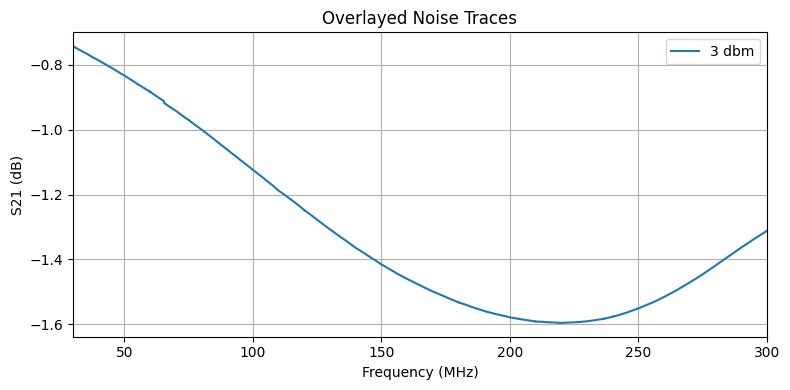

Identified peak frequencies (MHz): [ 30.0810081  60.         64.8874887  65.4005401  65.9675968  85.0045005
 119.972997 ]


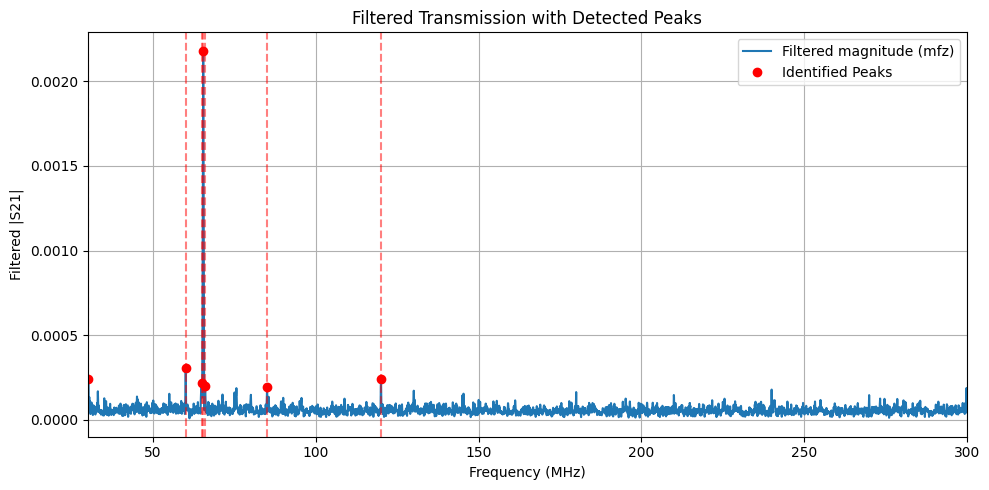

In [125]:
# filename =   # Replace with your actual file name
# freqs, s21 = load_noise_data(filename)
# plot_noise_trace(freqs, s21)


# Example usage
folder = '/central/home/xjw/workdir/qkid/PAA-KIPM/data/2025-6-20-paa-pcb-data/'
file_small_power = folder+'2025_6_20_xjw_noise_trace_ifbw_1000_hz.csv'
file_large_power = folder+'2025_6_20_xjw_noise_trace_ifbw_10_hz_power_3dm.csv'
# file_list = [file_small_power, file_large_power]  # Replace with your filenames
file_list = [file_large_power]  # Replace with your filenames
# file_list_leg = ["-55 dbm", "3 dbm"]  # Replace with your filenames
file_list_leg = ["3 dbm"]  # Replace with your filenames
freqs, s21 = overlay_traces(file_list, file_list_leg)

freqs_ghz = freqs/1e9
peak_search(freqs_ghz, s21)
plot_filtered_trace_with_peaks(freqs_ghz, s21)

In [126]:
def plot_raw_trace_60mhz(f, s21_db):
    # Convert f to MHz for plotting
    f_mhz = f * 1e3

    # Determine center frequency and plot ±30 MHz
    f_center_mhz = np.mean(f_mhz)
    f_min = f_center_mhz - 30
    f_max = f_center_mhz + 30

    plt.figure(figsize=(10, 4))
    plt.plot(f_mhz, s21_db, label='Raw S21 (dB)', color='blue')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('S21 (dB)')
    plt.title('Raw Transmission Trace (±30 MHz)')
    plt.xlim(f_min, f_max)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()